# Tutorial 1: How to use abcTau package to fit autocorrelations or PSDs

Details of the method are explained in:   
Zeraati, R., Engel, T. A. & Levina, A. A flexible Bayesian framework for unbiased estimation of timescales Computations. bioRxiv 2020.08.11.245944 (2021). https://www.biorxiv.org/content/10.1101/2020.08.11.245944v2

To start you need to have:
Python >= 3.7.1,
Numpy >= 1.15.4 ,
Scipy >= 1.1.0. 

and for visualizations:
Matplotlib >= 3.0.2,
Seaborn >= 0.9.0 

You can install seaborn from https://seaborn.pydata.org/installing.html 

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # comment this line if you don't want to use seaborn for plots

import numpy as np
from scipy import stats

# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
import abcTau


# graphical properties for figures
sns.set_context('talk',font_scale= 1.5)
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8" 
plt.rcParams.update({'font.size': 12})

# Step 1: Extracting required statistics from real data

First load your data and use "extract_stats" functions to compute statistics.

In [12]:
#---------- load real data  (OU process with one timescale)
dataload_path = 'example_data/'
filename = 'OU_tau100_T1000_fs1000_trials500'
data_load = np.load(dataload_path + filename + '.npy')

#---------- extract statistics from real data
# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = 500 # only used when suing autocorrelation for summary statistic s
lm = round(maxTimeLag/binSize) # maximum bin for autocorrelation computation
data_ac, data_mean, data_var, T, numTrials = abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)

# Step 2 (optional): Check the bias in timescales estimated from exponential fits (preprocessing module using prametric bootstrapping)

45% bootstrap-error
The true error from the ground truth can be larger


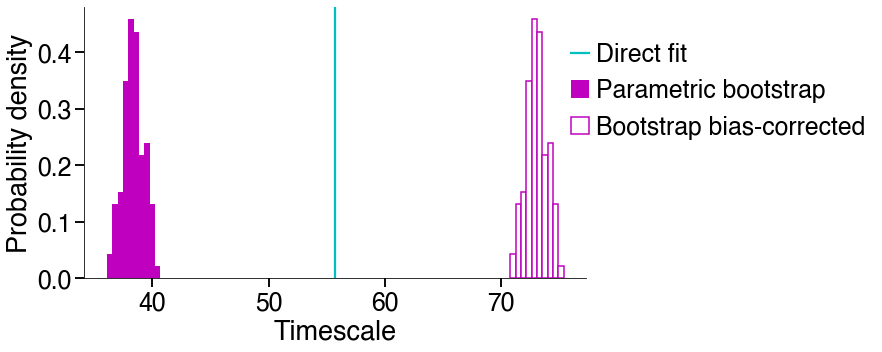

In [13]:
gt_tau = 100 # ground-truth timescale

# fit 
popt, poptcov = abcTau.preprocessing.fit_oneTauExponential(data_ac, binSize, maxTimeLag)
tau = popt[1]

# check if estimated timescales with exponential fit are biased or not
theta = np.array([tau])
numTimescales = 1
taus_bs, taus_bs_corr, err = abcTau.preprocessing.check_expEstimates(theta, deltaT, binSize, T, numTrials, \
                                                                     data_mean, data_var, maxTimeLag, numTimescales,\
                                                                     numIter = 100, plot_it = True)

This result inidicates that the direct exponential fitting gives biased estimates with the current amount of data. We can use the aABC algorithm to get a more accurate estimation of timescales. aABC additionally provides the posterior distribution of timescales that we can use for model comparison (see Tutorial 2)

# Step 3: Estimation of timescales using the aABC algorithm

In the following, we explain how to customize your own Python script step-by-step such that it best fits your data and your desired generative model. We provided 3 different examples:
1) Fitting one timescale in time domain
2) Fitting one timescale in frequency domain
3) Fitting two timescales in time domain

The duration for fitting the generative model with the aABC algorithm depends on the size of your data, selected summary statistics (e.g., fastest is with the PSD), number of accepted samples in posteriors (min_samples), final selected accepatance rate (minAccRate), and computational resources (e.g., number of cores in parallel processing). Depending on these parameters the fitting duration is in between ~20 min (usually for fitting PSDs) up to ~4-8 hours.



### [1]  Fitting a general type of generative model in the time domain:
This example takes about 2 hours to run on a normal computer without any parallel processing, using parallel computing (parallel = True) can speed up the fitting at least to half of this duration. You can check the provided example Python scripts for parallel processing.

The following is the example in Fig. 3A.

1) import the package and set the parameters for parallel processing (if applicable):

In [4]:
# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the package
import abcTau 
import numpy as np
from scipy import stats

# stetting the number of cores for each numpy computation in multiprocessing
# import os
# os.environ["OMP_NUM_THREADS"] = "2" 
# os.environ["OPENBLAS_NUM_THREADS"] = "2" 
# os.environ["MKL_NUM_THREADS"] = "2" 
# os.environ["VECLIB_MAXIMUM_THREADS"] = "2" 
# os.environ["NUMEXPR_NUM_THREADS"] = "2" 

2) Define the directories and filenames for loading the data and saving the results

In [5]:
# path for loading and saving data
datasave_path = 'example_abc_results/'
dataload_path = 'example_data/'

# path and filename to save the intermediate results after running each step
inter_save_direc = 'example_abc_results/'
inter_filename = 'abc_intermediate_results'

# define filename for loading and saving the results
filename = 'OU_tau20_mean0_var1_rawData'
filenameSave = filename

3) Load the real data and extract required statistics

In [6]:
# load data time-series as a numpy array (numTrials * time-points)
data_load = np.load(dataload_path + filename + '.npy')

# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = 50 # only used when suing autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)

4) Define the prior distributions

In [7]:
# Define a uniform prior distribution over the given range
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t_min = 0.0 # first timescale
t_max = 100.0
priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]

5) Select the desired generative model from the list of 'generative_models.py' and the distance function from 'diatance_functions.py'

In [8]:
# select generative model and distance function
generativeModel = 'oneTauOU'
distFunc = 'linear_distance'

6) Set the aABC fitting parameters

In [9]:
# set fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.01 # minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)

7) Create the model object: Just copy paste the following (this a general definition of the model object, but all parts including generative models, summary statistics computation or distance function can be replaced by your own functions. You can add your handmade functions inside respected modules: "generative_models.py", "distance_functions.py", "summary_stats.py")

In [10]:
# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d

8) Run the aABC algorithm and save the results

In [12]:
# fit with aABC algorithm for any generative model
abc_results, final_step = abcTau.fit.fit_withABC(MyModel, data_sumStat, priorDist, inter_save_direc, inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp)

Done :) 

Just copy paste the content of all the above cells in a text file and rename it to "scriptName.py"

Then, run it from terminal as: python scriptName.py

### [2]  Fitting a general type of generative model in the frequency domain:

Depending on your application you can also use the aABC method to extract timescales and other parameters from the frequency domain by fitting the sample power spectrum density (PSD).

For this purpose, we use exactly the same script as for the time domain, and only replace the autocorrelation computation with PSD computation.

### Attention! You should use exactly the same method for computing the PSD of real data and synthetic data!

We have implemented a simple PSD estimation function in the abcTau package but depending on your application, you can replace it with any other method such as methods avaiable in Scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html

However, the result of aABC algorithm generally does not depend on the choise of PSD computation method, as long as the same method is used for both real and synthetic data.

This example takes about 1 hour and 20 min to run on a normal computer without any parallel processing, using parallel computing can speed up the fitting to a few minutes.

In [1]:
# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the package
import abcTau 
import numpy as np
from scipy import stats

# stetting the number of cores for each numpy computation in multiprocessing
# import os
# os.environ["OMP_NUM_THREADS"] = "2" 
# os.environ["OPENBLAS_NUM_THREADS"] = "2" 
# os.environ["MKL_NUM_THREADS"] = "2" 
# os.environ["VECLIB_MAXIMUM_THREADS"] = "2" 
# os.environ["NUMEXPR_NUM_THREADS"] = "2" 
    
    
# path for loading and saving data
datasave_path = 'example_abc_results/'
dataload_path = 'example_data/'

# path and filename to save the intermediate results after running each step
inter_save_direc = 'example_abc_results/'
inter_filename = 'abc_intermediate_results_psd'

# load real data and define filenameSave
filename = 'OU_tau20_mean0_var1_rawData'
filenameSave = filename
print(filename)
data_load = np.load(dataload_path + filename + '.npy')

# load data time-series as a numpy array (numTrials * time-points)
data_load = np.load(dataload_path + filename + '.npy')

# select summary statistics metric
summStat_metric = 'comp_psd'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = None # only used when suing autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)



# Define the prior distribution
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t_min = 0.0 # first timescale
t_max = 100.0
priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]


# select generative model and distance function
generativeModel = 'oneTauOU'
distFunc = 'logarithmic_distance'


# set fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.01 # minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)


# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d


# fit with aABC algorithm for any generative model
abc_results, final_step = abcTau.fit.fit_withABC(MyModel, data_sumStat, priorDist, inter_save_direc, inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp)

### [3] Fitting the specific case of a two-timescales generative model in the time domain:

We developed a bit different function for fitting the two-timescales generative models to help them converge faster. While you always can use the above script for all models, the following options might help to speed up the fitting when your model have two timescales.

The following is the example in Fig. 3C.

1) define directories and prepare the model object same as above:

In [1]:
# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the package
import abcTau 
import numpy as np
from scipy import stats

# stetting the number of cores for each numpy computation in multiprocessing
# import os
# os.environ["OMP_NUM_THREADS"] = "2" 
# os.environ["OPENBLAS_NUM_THREADS"] = "2" 
# os.environ["MKL_NUM_THREADS"] = "2" 
# os.environ["VECLIB_MAXIMUM_THREADS"] = "2" 
# os.environ["NUMEXPR_NUM_THREADS"] = "2" 
    
    
# path for loading and saving data
datasave_path = 'example_abc_results/'
dataload_path = 'example_data/'

# path and filename to save the intermediate results after running each step
inter_save_direc = 'example_abc_results/'
inter_filename = 'abc_intermediate_results'


# Define the prior distribution
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t1_min = 0.0 # first timescale
t1_max = 60.0
t2_min = 20.0 # second timescale
t2_max = 140.0
coef_min = 0.0 # coeffiecient or weight of the first timescale
coef_max = 1.0
priorDist = [stats.uniform(loc= t1_min, scale = t1_max - t1_min),\
             stats.uniform(loc= t2_min, scale = t2_max - t2_min),\
             stats.uniform(loc= coef_min, scale = coef_max - coef_min)] 


# select generative model and distance function
generativeModel = 'twoTauOU_poissonSpikes'
distFunc = 'linear_distance'


# load real data and define filenameSave
filename = 'inhomPois_tau5_80_coeff04_T1000_trials500_deltaT1_data_mean1_data_var1.25'
filenameSave = filename
print(filename)
data_load = np.load(dataload_path + filename + '.npy')

# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = 110 # only used when suing autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)



# set fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.01 # minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)


# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d

inhomPois_tau5_80_coeff04_T1000_trials500_deltaT1_data_mean1_data_var1.25


2) But instead use the following function for fitting:

In [2]:
# fit with aABC algorithm for the two-timescales generative model
abc_results, final_step = abcTau.fit.fit_withABC_2Tau(MyModel, data_sumStat, priorDist, inter_save_direc,\
                                                      inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp)

# Resuming a previous aABC fit and let it run for more iterations 

It's possible to resume a previous fit with the aABC method and allow it to run from the point it stopped. This functionality is useful when the initial stopping criterion (e.g., minimum acceptance rate) was not sufficient to obtain narrow posteriors and you need better statistics for the fits without running the aABC fit from the beginning.

In [1]:
# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the package
import abcTau 
import numpy as np
from scipy import stats
# stetting the number of cores for each numpy computation in multiprocessing
# import os
# os.environ["OMP_NUM_THREADS"] = "2" 
# os.environ["OPENBLAS_NUM_THREADS"] = "2"
# os.environ["MKL_NUM_THREADS"] = "2" 
# os.environ["VECLIB_MAXIMUM_THREADS"] = "2"
# os.environ["NUMEXPR_NUM_THREADS"] = "2"
    
    
# path for loading and saving data
datasave_path = 'example_abc_results/'
dataload_path = 'example_data/'

# path and filename to save the intermediate results after running each step
inter_save_direc = 'example_abc_results/'
inter_filename = 'abc_intermediate_results'

# load real data and define filenameSave
filename = 'OU_tau20_T1000_trials500_deltaT1_data_mean0_data_var1'
filenameSave = filename
print(filename)
data_load = np.load(dataload_path + filename + '.npy')

# select summary statistics metric
summStat_metric = 'comp_ac_fft'
ifNorm = True # if normalize the autocorrelation or PSD

# extract statistics from real data
deltaT = 1 # temporal resolution of data.
binSize = 1 #  bin-size for binning data and computing the autocorrelation.
disp = None # put the disperssion parameter if computed with grid-search
maxTimeLag = 50 # only used when suing autocorrelation for summary statistics
data_sumStat, data_mean, data_var, T, numTrials =  abcTau.preprocessing.extract_stats(data_load, deltaT, binSize,\
                                                                                  summStat_metric, ifNorm, maxTimeLag)


# Define the prior distribution
# for a uniform prior: stats.uniform(loc=x_min,scale=x_max-x_min)
t_min = 0.0 # first timescale
t_max = 100.0
priorDist = [stats.uniform(loc= t_min, scale = t_max - t_min)]


# select generative model and distance function
generativeModel = 'oneTauOU'
distFunc = 'linear_distance'


# creating model object
class MyModel(abcTau.Model):

    #This method initializes the model object.  
    def __init__(self):
        pass

    # draw samples from the prior. 
    def draw_theta(self):
        theta = []
        for p in self.prior:
            theta.append(p.rvs())
        return theta

    # Choose the generative model (from generative_models)
    # Choose autocorrelation computation method (from basic_functions)
    def generate_data(self, theta):
        # generate synthetic data
        if disp == None:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var)')
        else:
            syn_data, numBinData =  eval('abcTau.generative_models.' + generativeModel + \
                                         '(theta, deltaT, binSize, T, numTrials, data_mean, data_var, disp)')
               
        # compute the summary statistics
        syn_sumStat = abcTau.summary_stats.comp_sumStat(syn_data, summStat_metric, ifNorm, deltaT, binSize, T,\
                                          numBinData, maxTimeLag)   
        return syn_sumStat

    # Computes the summary statistics
    def summary_stats(self, data):
        sum_stat = data
        return sum_stat

    # Choose the method for computing distance (from basic_functions)
    def distance_function(self, data, synth_data):
        if np.nansum(synth_data) <= 0: # in case of all nans return large d to reject the sample
            d = 10**4
        else:
            d = eval('abcTau.distance_functions.' +distFunc + '(data, synth_data)')        
        return d

OU_tau20_T1000_trials500_deltaT1_data_mean0_data_var1


In [3]:
# load the previous aABC fit
data_abc_path = 'example_abc_results/'
filename = '1on_OU_tau20_T1000_lag50_steps43'
abc_results = np.load(data_abc_path + filename + '.npy', allow_pickle=True)
ind = filename.find('steps') 
final_step = int(filename[ind+5] + filename[ind+6])
abc_results_old = abc_results[:final_step]

# set new fitting params
epsilon_0 = 1  # initial error threshold
min_samples = 100 # min samples from the posterior
steps = 60 # max number of iterations
minAccRate = 0.005 # new minimum acceptance rate to stop the iterations
parallel = False # if parallel processing
n_procs = 1 # number of processor for parallel processing (set to 1 if there is no parallel processing)

In [9]:
# resume the aABC fitting
abc_results, final_step = abcTau.fit.fit_withABC(MyModel, data_sumStat, priorDist, inter_save_direc,\
                                                             inter_filename,\
                                                 datasave_path,filenameSave, epsilon_0, min_samples, \
                                                 steps, minAccRate, parallel, n_procs, disp, resume = abc_results_old)